## ResNet

#### Include Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import sys
from tqdm import tqdm
import numpy as np
import sklearn.metrics as metrics


#### Load Data from folder

In [10]:
data_root = './data/train'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    
])

all_data = ImageFolder(data_root, transform=transform)
print(all_data.class_to_idx)

{'Changhua_County': 0, 'Chiayi_City': 1, 'Chiayi_County': 2, 'Hsinchu_City': 3, 'Hsinchu_County': 4, 'Hualien_County': 5, 'Kaohsiung_City': 6, 'Keelung_City': 7, 'Miaoli_County': 8, 'Nantou_County': 9, 'New_Taipei_City': 10, 'Pingtung_County': 11, 'Taichung_City': 12, 'Tainan_City': 13, 'Taipei_City': 14, 'Taitung_County': 15, 'Taoyuan_City': 16, 'Yilan_County': 17, 'Yunlin_County': 18}


#### Read Data To DataLoader

In [11]:
# split the data into training and testing sets
batch_size = 32

train_size = int(0.8 * len(all_data))
test_size = len(all_data) - train_size


train_dataset, test_dataset = torch.utils.data.random_split(all_data, [train_size, test_size])

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Print the sizes of the datasets
print(f'Training set size: {len(train_dataset)}')
print(f'Testing set size: {len(test_dataset)}')


Training set size: 3646
Testing set size: 912


#### Construct the Network

In [ ]:
# Load the pre-trained ResNet model
resnet = models.resnet34(pretrained=True)

# Get the number of classes in the dataset
nums_classes = len(all_data.classes)

# Change the last layer of the model to output the number of classes in our dataset
resnet.fc = nn.Linear(resnet.fc.in_features, nums_classes)


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0000025)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet.to(device)

/home/NYCU/AI_Capstone_project1/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/NYCU/AI_Capstone_project1/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Run Training

In [ ]:

# Set the number of epochs
num_epochs = 50

print(f"device: {device}")

# Record the data for plotting
train_loss_list = []
test_loss_list = []
test_accuracy_list = []
test_precision_list = []
test_recall_list = []
test_f1_list = []

best_loss = 10000

for epoch in range(num_epochs):
    print('Epoch:', epoch + 1)
    resnet.train()
    train_running_loss = 0.0
    test_running_loss = 0.0

    # Train the model
    print('start training')
    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        train_outputs = resnet(images)
        
        loss = loss_fn(train_outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_running_loss += loss.item()
    
    resnet.eval()
    sys.stdout.flush()
    print('start testing')
    y_pred = []
    y_true = []
    accuracy = 0

    # Use Validation set to evaluate the model
    for images, labels in tqdm(test_dataloader):
        images, labels = images.to(device), labels.to(device)
        test_outputs = resnet(images)
        y_pred.extend(torch.argmax(test_outputs, dim=1).cpu())
        y_true.extend(labels.cpu())

        loss = loss_fn(test_outputs, labels)
        test_running_loss += loss.item()
    
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # Calculate the accuracy, precision, recall, and F1 score on the validation set
    test_accuracy = metrics.accuracy_score(y_true, y_pred)
    test_precision = metrics.precision_score(y_true, y_pred, average='macro')
    test_recall = metrics.recall_score(y_true, y_pred, average='macro')
    test_f1 = metrics.f1_score(y_true, y_pred, average='macro')

    # Calculate the average loss
    train_running_loss = train_running_loss / len(train_dataloader)
    test_running_loss = test_running_loss / len(test_dataloader)

    # Save the model with the best loss
    if(test_running_loss < best_loss):
        best_loss = test_running_loss
        torch.save(resnet.state_dict(), 'best_model.pth')
    
    print(f'Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}')
    
    # Record the data for plotting
    test_accuracy_list.append(test_accuracy)
    test_precision_list.append(test_precision)
    test_recall_list.append(test_recall)
    test_f1_list.append(test_f1)
    train_loss_list.append(train_running_loss)
    test_loss_list.append(test_running_loss)

    print(f'Epoch {epoch + 1}, train loss: {train_running_loss:.4f}, test loss: {test_running_loss:.4f}')
    


device: cuda
Epoch: 1
start training


100%|██████████| 114/114 [00:14<00:00,  7.74it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.71it/s]


Accuracy: 0.1195, Precision: 0.1053, Recall: 0.1234, F1: 0.1068
Epoch 1, train loss: 1.8224, test loss: 2.8095
Epoch: 2
start training


100%|██████████| 114/114 [00:14<00:00,  7.72it/s]


start testing


100%|██████████| 29/29 [00:05<00:00,  5.76it/s]


Accuracy: 0.1206, Precision: 0.1212, Recall: 0.1223, F1: 0.1105
Epoch 2, train loss: 1.7784, test loss: 2.8034
Epoch: 3
start training


100%|██████████| 114/114 [00:14<00:00,  7.85it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.07it/s]


Accuracy: 0.1239, Precision: 0.1170, Recall: 0.1257, F1: 0.1151
Epoch 3, train loss: 1.7134, test loss: 2.8244
Epoch: 4
start training


100%|██████████| 114/114 [00:15<00:00,  7.26it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.28it/s]


Accuracy: 0.1261, Precision: 0.1246, Recall: 0.1295, F1: 0.1191
Epoch 4, train loss: 1.6229, test loss: 2.8308
Epoch: 5
start training


100%|██████████| 114/114 [00:14<00:00,  7.76it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.86it/s]


Accuracy: 0.1173, Precision: 0.1125, Recall: 0.1178, F1: 0.1088
Epoch 5, train loss: 1.5603, test loss: 2.8477
Epoch: 6
start training


100%|██████████| 114/114 [00:15<00:00,  7.42it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.46it/s]


Accuracy: 0.1239, Precision: 0.1206, Recall: 0.1278, F1: 0.1153
Epoch 6, train loss: 1.4696, test loss: 2.8698
Epoch: 7
start training


100%|██████████| 114/114 [00:13<00:00,  8.75it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.31it/s]


Accuracy: 0.1184, Precision: 0.1120, Recall: 0.1199, F1: 0.1104
Epoch 7, train loss: 1.3718, test loss: 2.8636
Epoch: 8
start training


100%|██████████| 114/114 [00:14<00:00,  7.84it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.81it/s]


Accuracy: 0.1184, Precision: 0.1174, Recall: 0.1197, F1: 0.1140
Epoch 8, train loss: 1.3116, test loss: 2.8716
Epoch: 9
start training


100%|██████████| 114/114 [00:13<00:00,  8.19it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.19it/s]


Accuracy: 0.1195, Precision: 0.1154, Recall: 0.1230, F1: 0.1126
Epoch 9, train loss: 1.2439, test loss: 2.8958
Epoch: 10
start training


100%|██████████| 114/114 [00:14<00:00,  7.77it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.75it/s]


Accuracy: 0.1217, Precision: 0.1151, Recall: 0.1233, F1: 0.1145
Epoch 10, train loss: 1.1561, test loss: 2.9289
Epoch: 11
start training


100%|██████████| 114/114 [00:13<00:00,  8.50it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.60it/s]


Accuracy: 0.1140, Precision: 0.1161, Recall: 0.1164, F1: 0.1080
Epoch 11, train loss: 1.0775, test loss: 2.9245
Epoch: 12
start training


100%|██████████| 114/114 [00:15<00:00,  7.49it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.77it/s]


Accuracy: 0.1184, Precision: 0.1165, Recall: 0.1200, F1: 0.1138
Epoch 12, train loss: 1.0371, test loss: 2.9636
Epoch: 13
start training


100%|██████████| 114/114 [00:13<00:00,  8.32it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.70it/s]


Accuracy: 0.1053, Precision: 0.1152, Recall: 0.1077, F1: 0.1052
Epoch 13, train loss: 0.9794, test loss: 2.9873
Epoch: 14
start training


100%|██████████| 114/114 [00:15<00:00,  7.30it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.97it/s]


Accuracy: 0.1162, Precision: 0.1109, Recall: 0.1174, F1: 0.1117
Epoch 14, train loss: 0.8751, test loss: 2.9812
Epoch: 15
start training


100%|██████████| 114/114 [00:13<00:00,  8.17it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.54it/s]


Accuracy: 0.1020, Precision: 0.1097, Recall: 0.1042, F1: 0.1011
Epoch 15, train loss: 0.8326, test loss: 3.0343
Epoch: 16
start training


100%|██████████| 114/114 [00:15<00:00,  7.27it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.26it/s]


Accuracy: 0.1129, Precision: 0.1126, Recall: 0.1133, F1: 0.1092
Epoch 16, train loss: 0.7689, test loss: 3.0177
Epoch: 17
start training


100%|██████████| 114/114 [00:14<00:00,  8.13it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.03it/s]


Accuracy: 0.1151, Precision: 0.1166, Recall: 0.1174, F1: 0.1102
Epoch 17, train loss: 0.7044, test loss: 3.0483
Epoch: 18
start training


100%|██████████| 114/114 [00:15<00:00,  7.45it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.74it/s]


Accuracy: 0.1250, Precision: 0.1264, Recall: 0.1253, F1: 0.1212
Epoch 18, train loss: 0.6648, test loss: 3.0437
Epoch: 19
start training


100%|██████████| 114/114 [00:14<00:00,  7.83it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.32it/s]


Accuracy: 0.1031, Precision: 0.1073, Recall: 0.1031, F1: 0.1005
Epoch 19, train loss: 0.5976, test loss: 3.0962
Epoch: 20
start training


100%|██████████| 114/114 [00:16<00:00,  6.96it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.47it/s]


Accuracy: 0.1184, Precision: 0.1182, Recall: 0.1193, F1: 0.1154
Epoch 20, train loss: 0.5729, test loss: 3.0826
Epoch: 21
start training


100%|██████████| 114/114 [00:14<00:00,  7.65it/s]


start testing


100%|██████████| 29/29 [00:04<00:00,  6.45it/s]


Accuracy: 0.1107, Precision: 0.1135, Recall: 0.1130, F1: 0.1080
Epoch 21, train loss: 0.5093, test loss: 3.1297
Epoch: 22
start training


100%|██████████| 114/114 [00:14<00:00,  7.79it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.30it/s]


Accuracy: 0.1129, Precision: 0.1176, Recall: 0.1132, F1: 0.1114
Epoch 22, train loss: 0.4859, test loss: 3.1220
Epoch: 23
start training


100%|██████████| 114/114 [00:15<00:00,  7.40it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.71it/s]


Accuracy: 0.1075, Precision: 0.1078, Recall: 0.1065, F1: 0.1040
Epoch 23, train loss: 0.4182, test loss: 3.1522
Epoch: 24
start training


100%|██████████| 114/114 [00:14<00:00,  7.79it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.73it/s]


Accuracy: 0.1042, Precision: 0.1098, Recall: 0.1025, F1: 0.1029
Epoch 24, train loss: 0.4084, test loss: 3.1796
Epoch: 25
start training


100%|██████████| 114/114 [00:15<00:00,  7.48it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.82it/s]


Accuracy: 0.1053, Precision: 0.1104, Recall: 0.1050, F1: 0.1031
Epoch 25, train loss: 0.3632, test loss: 3.2047
Epoch: 26
start training


100%|██████████| 114/114 [00:14<00:00,  7.63it/s]


start testing


100%|██████████| 29/29 [00:05<00:00,  4.95it/s]


Accuracy: 0.1020, Precision: 0.1104, Recall: 0.1026, F1: 0.1027
Epoch 26, train loss: 0.3545, test loss: 3.2258
Epoch: 27
start training


100%|██████████| 114/114 [00:15<00:00,  7.34it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.26it/s]


Accuracy: 0.1129, Precision: 0.1155, Recall: 0.1147, F1: 0.1105
Epoch 27, train loss: 0.3102, test loss: 3.2031
Epoch: 28
start training


100%|██████████| 114/114 [00:13<00:00,  8.24it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.87it/s]


Accuracy: 0.1053, Precision: 0.1075, Recall: 0.1057, F1: 0.1029
Epoch 28, train loss: 0.2870, test loss: 3.2149
Epoch: 29
start training


100%|██████████| 114/114 [00:15<00:00,  7.21it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.03it/s]


Accuracy: 0.1031, Precision: 0.1089, Recall: 0.1031, F1: 0.1018
Epoch 29, train loss: 0.2932, test loss: 3.2544
Epoch: 30
start training


100%|██████████| 114/114 [00:14<00:00,  7.79it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.56it/s]


Accuracy: 0.1020, Precision: 0.1052, Recall: 0.1023, F1: 0.0995
Epoch 30, train loss: 0.2645, test loss: 3.2859
Epoch: 31
start training


100%|██████████| 114/114 [00:15<00:00,  7.17it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.67it/s]


Accuracy: 0.1086, Precision: 0.1065, Recall: 0.1071, F1: 0.1040
Epoch 31, train loss: 0.2352, test loss: 3.2873
Epoch: 32
start training


100%|██████████| 114/114 [00:13<00:00,  8.18it/s]


start testing


100%|██████████| 29/29 [00:04<00:00,  6.62it/s]


Accuracy: 0.1042, Precision: 0.1072, Recall: 0.1042, F1: 0.1028
Epoch 32, train loss: 0.2032, test loss: 3.2800
Epoch: 33
start training


100%|██████████| 114/114 [00:14<00:00,  7.66it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.82it/s]


Accuracy: 0.1009, Precision: 0.1057, Recall: 0.1012, F1: 0.0999
Epoch 33, train loss: 0.2181, test loss: 3.2954
Epoch: 34
start training


100%|██████████| 114/114 [00:15<00:00,  7.25it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.18it/s]


Accuracy: 0.0921, Precision: 0.0987, Recall: 0.0930, F1: 0.0916
Epoch 34, train loss: 0.1976, test loss: 3.3246
Epoch: 35
start training


100%|██████████| 114/114 [00:14<00:00,  7.82it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.63it/s]


Accuracy: 0.1129, Precision: 0.1151, Recall: 0.1113, F1: 0.1110
Epoch 35, train loss: 0.1600, test loss: 3.2929
Epoch: 36
start training


100%|██████████| 114/114 [00:16<00:00,  6.91it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  8.84it/s]


Accuracy: 0.0943, Precision: 0.0929, Recall: 0.0946, F1: 0.0920
Epoch 36, train loss: 0.1638, test loss: 3.3099
Epoch: 37
start training


100%|██████████| 114/114 [00:14<00:00,  7.63it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.49it/s]


Accuracy: 0.0932, Precision: 0.0977, Recall: 0.0939, F1: 0.0893
Epoch 37, train loss: 0.1497, test loss: 3.4005
Epoch: 38
start training


100%|██████████| 114/114 [00:16<00:00,  6.96it/s]


start testing


100%|██████████| 29/29 [00:02<00:00, 10.16it/s]


Accuracy: 0.0976, Precision: 0.1005, Recall: 0.0991, F1: 0.0972
Epoch 38, train loss: 0.1460, test loss: 3.3546
Epoch: 39
start training


100%|██████████| 114/114 [00:14<00:00,  7.81it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.87it/s]


Accuracy: 0.1086, Precision: 0.1110, Recall: 0.1069, F1: 0.1053
Epoch 39, train loss: 0.1426, test loss: 3.3743
Epoch: 40
start training


100%|██████████| 114/114 [00:18<00:00,  6.13it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  7.44it/s]


Accuracy: 0.1086, Precision: 0.1051, Recall: 0.1087, F1: 0.1047
Epoch 40, train loss: 0.1337, test loss: 3.4080
Epoch: 41
start training


100%|██████████| 114/114 [00:14<00:00,  8.03it/s]


start testing


100%|██████████| 29/29 [00:04<00:00,  6.33it/s]


Accuracy: 0.1107, Precision: 0.1103, Recall: 0.1100, F1: 0.1068
Epoch 41, train loss: 0.1212, test loss: 3.4245
Epoch: 42
start training


100%|██████████| 114/114 [00:14<00:00,  8.01it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.47it/s]


Accuracy: 0.1031, Precision: 0.1052, Recall: 0.1027, F1: 0.1001
Epoch 42, train loss: 0.1176, test loss: 3.4046
Epoch: 43
start training


100%|██████████| 114/114 [00:17<00:00,  6.62it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  8.66it/s]


Accuracy: 0.1053, Precision: 0.1104, Recall: 0.1059, F1: 0.1039
Epoch 43, train loss: 0.1106, test loss: 3.4086
Epoch: 44
start training


100%|██████████| 114/114 [00:14<00:00,  7.89it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.86it/s]


Accuracy: 0.1020, Precision: 0.1007, Recall: 0.1021, F1: 0.0991
Epoch 44, train loss: 0.0959, test loss: 3.3898
Epoch: 45
start training


100%|██████████| 114/114 [00:15<00:00,  7.35it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.64it/s]


Accuracy: 0.1053, Precision: 0.1093, Recall: 0.1050, F1: 0.1035
Epoch 45, train loss: 0.0946, test loss: 3.4106
Epoch: 46
start training


100%|██████████| 114/114 [00:14<00:00,  7.97it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.78it/s]


Accuracy: 0.0965, Precision: 0.0989, Recall: 0.0937, F1: 0.0936
Epoch 46, train loss: 0.1030, test loss: 3.4603
Epoch: 47
start training


100%|██████████| 114/114 [00:15<00:00,  7.24it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.96it/s]


Accuracy: 0.0954, Precision: 0.0961, Recall: 0.0963, F1: 0.0926
Epoch 47, train loss: 0.0832, test loss: 3.4382
Epoch: 48
start training


100%|██████████| 114/114 [00:14<00:00,  8.01it/s]


start testing


100%|██████████| 29/29 [00:02<00:00,  9.78it/s]


Accuracy: 0.0976, Precision: 0.1018, Recall: 0.0990, F1: 0.0968
Epoch 48, train loss: 0.0831, test loss: 3.4653
Epoch: 49
start training


100%|██████████| 114/114 [00:15<00:00,  7.34it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.34it/s]


Accuracy: 0.0965, Precision: 0.0983, Recall: 0.0979, F1: 0.0944
Epoch 49, train loss: 0.0855, test loss: 3.4588
Epoch: 50
start training


100%|██████████| 114/114 [00:14<00:00,  7.97it/s]


start testing


100%|██████████| 29/29 [00:03<00:00,  9.46it/s]

Accuracy: 0.0998, Precision: 0.1059, Recall: 0.0992, F1: 0.0992
Epoch 50, train loss: 0.0769, test loss: 3.4619


#### Draw loss and metrics chart

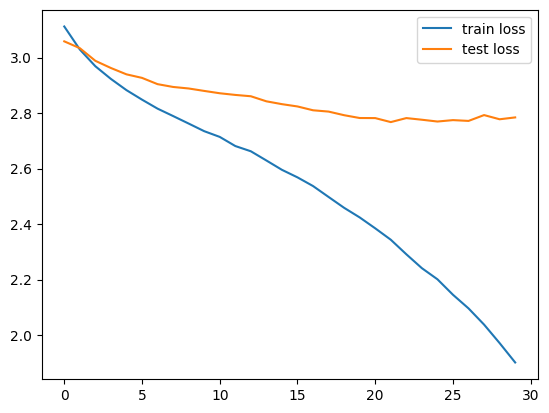

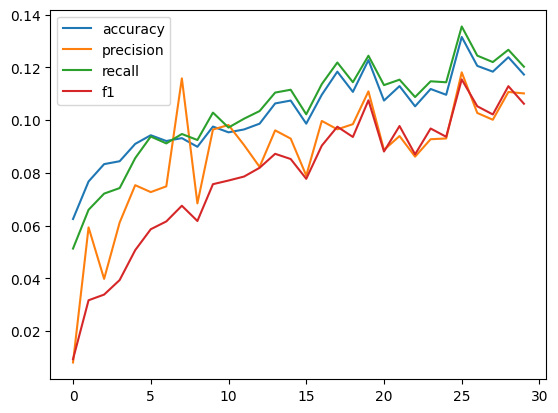

In [18]:
import matplotlib.pyplot as plt
plt.plot(train_loss_list, label='train loss')
plt.plot(test_loss_list, label='test loss')
plt.legend()
plt.show()

plt.plot(test_accuracy_list, label='accuracy')
plt.plot(test_precision_list, label='precision')
plt.plot(test_recall_list, label='recall')
plt.plot(test_f1_list, label='f1')
plt.legend()
plt.show()

#### Run the model on the test data

Accuracy: 0.2202
Precision: 0.2161
Recall: 0.2202
F1: 0.2154


<Axes: >

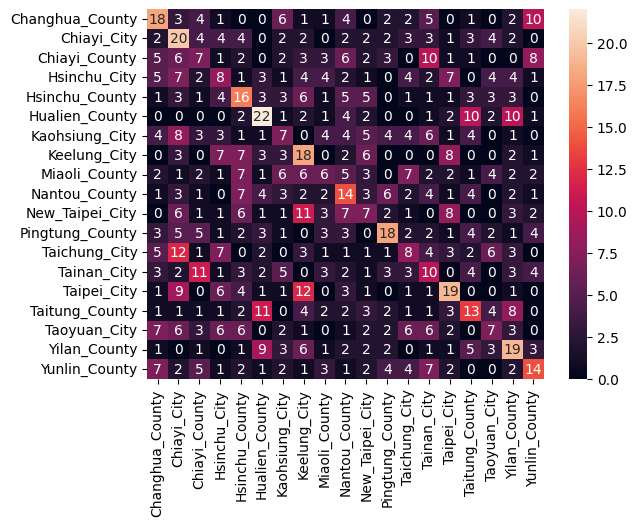

In [8]:
import sklearn.metrics as confusion_matrix
import numpy as np
import seaborn as sns

resnet.load_state_dict(torch.load('best_model.pth'))
resnet.eval()
y_true = []
y_pred = []

test_dataset = ImageFolder('./data/test', transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for images, labels in test_dataloader:
    images, labels = images.to(device), labels.to(device)
    outputs = resnet(images)
    _, predicted = torch.max(outputs, 1)
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

cm = (confusion_matrix.confusion_matrix(y_true, y_pred))
print(f"Accuracy: {metrics.accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {metrics.precision_score(y_true, y_pred, average='macro'):.4f}")
print(f"Recall: {metrics.recall_score(y_true, y_pred, average='macro'):.4f}")
print(f"F1: {metrics.f1_score(y_true, y_pred, average='macro'):.4f}")

sns.heatmap(cm, annot=True, xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)



#### Rearrange the confusion matrix

<Axes: >

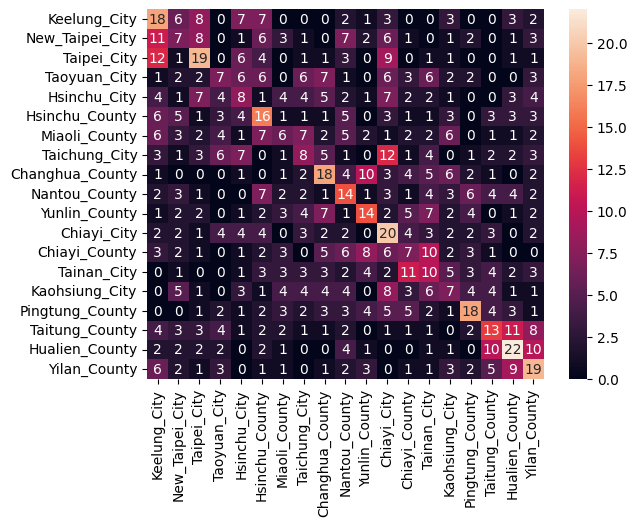

In [9]:
rearange_list = {'Keelung_City': 0, 'New_Taipei_City': 1, 'Taipei_City': 2, 'Taoyuan_City': 3, 'Hsinchu_City': 4, 'Hsinchu_County': 5, 'Miaoli_County': 6, 'Taichung_City': 7, 'Changhua_County': 8, 'Nantou_County': 9, 'Yunlin_County': 10, 'Chiayi_City': 11, 'Chiayi_County': 12, 'Tainan_City': 13, 'Kaohsiung_City': 14, 'Pingtung_County': 15, 'Taitung_County': 16, 'Hualien_County': 17, 'Yilan_County': 18}
city_list = ['Keelung_City', 'New_Taipei_City', 'Taipei_City', 'Taoyuan_City', 'Hsinchu_City', 'Hsinchu_County', 'Miaoli_County', 'Taichung_City', 'Changhua_County', 'Nantou_County', 'Yunlin_County', 'Chiayi_City', 'Chiayi_County', 'Tainan_City', 'Kaohsiung_City', 'Pingtung_County', 'Taitung_County', 'Hualien_County', 'Yilan_County']
new_index = {all_data.class_to_idx[city]: rearange_list[city] for city in city_list}

rearange_y_true = [new_index[i] for i in y_true]
rearange_y_pred = [new_index[i] for i in y_pred]

cm = confusion_matrix.confusion_matrix(rearange_y_true, rearange_y_pred)
sns.heatmap(cm, annot=True, xticklabels=city_list, yticklabels=city_list)
